<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_3rd_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [1]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz

--2021-07-23 00:50:51--  https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.216.160.91
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.216.160.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5075979 (4.8M) [text/csv]
Saving to: ‘test_data.csv’

test_data.csv       100%[===================>]   4.84M  --.-KB/s    in 0.1s    

2021-07-23 00:50:51 (48.3 MB/s) - ‘test_data.csv’ saved [5075979/5075979]

--2021-07-23 00:50:52--  https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.217.165.209
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.217.165.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81456239 (78M) [application/x-www-form-urle

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-07-23 00:51:09--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-07-23 00:51:09--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 135.181.209.10, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  28.8MB/s    in 8.5s    

2021-07-23 00:51:18 (26.5 MB/s) - ‘spark_tgz/spark-2

In [3]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 59 kB/s 
     |████████████████████████████████| 198 kB 61.3 MB/s 


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
import pandas as pd 
import numpy as np


In [7]:
df_spark = spark.read.format('parquet').load("train_data.parquet")

In [8]:
df_spark.count()

37660279

In [9]:
df_spark.createOrReplaceTempView('df')

In [10]:
spark.sql("""
SELECT df.*
  ,minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) diff_minutes_active
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) < 0 THEN 'Ruptura'END) Ruptura
  ,(CASE WHEN minutes_active - lag(minutes_active,1) over (partition by sku order by date asc) > 0 THEN 'Estoque'END) Estoque
  
FROM df
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')

In [11]:
spark.sql("""
SELECT df_re.*
  ,CASE WHEN Ruptura is null and Estoque is null and minutes_active>0 and diff_minutes_active is null then 'Estoque'
        --WHEN Estoque is not null then 'Estoque'
        WHEN minutes_active = diff_minutes_active	and Estoque is not null then 'Estoque'
        --WHEN Ruptura is not null and Estoque is null then 'Ruptura'
        WHEN Ruptura is not null and Estoque is null and minutes_active=0  then 'Ruptura'
        END STATUS_RUPTURA
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [12]:
spark.sql("""
SELECT df_re.*
  ,COUNT(CASE WHEN STATUS_RUPTURA IS NOT NULL THEN 1 END) over (partition by sku order by date ) ciclo_ruptura
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [13]:
spark.sql("""
SELECT df_re.*
  ,SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) sum_sold_quantity 
  ,sum(case when sold_quantity >0 then current_price*sold_quantity end) over (partition by sku,ciclo_ruptura order by date desc)/SUM(sold_quantity) over (partition by sku,ciclo_ruptura order by date desc) avg_current_price 
  ,SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) days_active_nround
  ,round(SUM(minutes_active) over (partition by sku,ciclo_ruptura order by date desc) /60/24 + 0.5,0) days_active 
FROM df_re
--where sku = 645793
--order by sku, date
""").createOrReplaceTempView('df_re')#.toPandas()

In [17]:
spark.sql("""
SELECT df_re.*  
  ,min(days_active_nround) over (partition by sku,ciclo_ruptura order by date desc)>=1 FLG_ruptura 
FROM df_re
--where sku = 0
--order by sku, date
""").filter('FLG_ruptura=True').drop(*['date','sold_quantity','minutes_active','diff_minutes_active',	'Ruptura',	'Estoque',	'STATUS_RUPTURA',	'ciclo_ruptura']).createOrReplaceTempView('df_final')#.toPandas()

In [18]:
%%time
spark.sql("""
SELECT *
FROM df_final
""").write.mode('overwrite').format('parquet').save('data/tabelao/')

CPU times: user 816 ms, sys: 100 ms, total: 916 ms
Wall time: 3min 7s


In [19]:
df = spark.read.format('parquet').load('data/tabelao/')

In [20]:
df.count()

28081550

In [21]:
df.repartition(1).write.mode('overwrite').format('parquet').save('data/tabela_final/')

In [23]:
from glob import glob 
loc_parquet = glob('data/tabela_final/*.parquet')
df = pd.read_parquet(loc_parquet[0])
#pd_df = df.toPandas()

In [24]:
df.head()

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active_nround,days_active,FLG_ruptura
0,264,1151.69,MEX,premium,fulfillment,free_shipping,6,1151.690000,1120.966667,1.0,True
1,264,1151.69,MEX,premium,fulfillment,free_shipping,19,1151.690000,2560.966667,2.0,True
2,264,1151.69,MEX,premium,fulfillment,free_shipping,24,1151.690000,4000.966667,3.0,True
3,264,1087.73,MEX,premium,fulfillment,free_shipping,33,1134.246364,5440.966667,4.0,True
4,264,1095.98,MEX,premium,fulfillment,free_shipping,53,1119.806226,6880.966667,5.0,True


In [25]:
df.shape

(28081550, 11)

In [26]:
df.loc[df.sku==264,:]

,sku,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,sum_sold_quantity,avg_current_price,days_active_nround,days_active,FLG_ruptura
0,264,1151.69,MEX,premium,fulfillment,free_shipping,6,1151.690000,1120.966667,1.0,True
1,264,1151.69,MEX,premium,fulfillment,free_shipping,19,1151.690000,2560.966667,2.0,True
2,264,1151.69,MEX,premium,fulfillment,free_shipping,24,1151.690000,4000.966667,3.0,True
3,264,1087.73,MEX,premium,fulfillment,free_shipping,33,1134.246364,5440.966667,4.0,True
4,264,1095.98,MEX,premium,fulfillment,free_shipping,53,1119.806226,6880.966667,5.0,True
5,264,1054.85,MEX,premium,fulfillment,free_shipping,64,1108.641875,8320.966667,6.0,True
6,264,1061.28,MEX,premium,fulfillment,free_shipping,84,1097.365238,9760.966667,7.0,True
7,264,1061.28,MEX,premium,fulfillment,free_shipping,93,1093.873118,11200.966667,8.0,True
8,264,1039.84,MEX,premium,fulfillment,free_shipping,107,1086.803364,12640.966667,9.0,True
9,264,1020.93,MEX,premium,fulfillment,free_shipping,127,1076.429606,14080.966667,10.0,True


In [27]:
df_test = pd.read_csv('test_data.csv')

In [28]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 12 kB/s 


In [29]:
from catboost import Pool, CatBoostClassifier

In [31]:
vars = ['sku',
 'sum_sold_quantity'
 ]
cat_vars =  ['sku'
 ]

In [32]:
from sklearn.model_selection import train_test_split

In [64]:
train_data,test_data,train_label,test_label = train_test_split(df,df.days_active,train_size=.02,test_size=.01)

In [65]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars)

# specify the training parameters 
model = CatBoostClassifier(task_type='GPU')#n_estimators=100,learning_rate=0.1)
#train the model
model.fit(train_pool)
# make the prediction using the resulting model

Learning rate set to 0.236141
0:	learn: 3.9382339	total: 627ms	remaining: 10m 26s
1:	learn: 3.8754129	total: 1.21s	remaining: 10m 2s
2:	learn: 3.8405595	total: 1.79s	remaining: 9m 54s
3:	learn: 3.8161088	total: 2.38s	remaining: 9m 52s
4:	learn: 3.7999723	total: 2.96s	remaining: 9m 49s
5:	learn: 3.7895081	total: 3.54s	remaining: 9m 47s
6:	learn: 3.7815648	total: 4.12s	remaining: 9m 45s
7:	learn: 3.7761800	total: 4.72s	remaining: 9m 44s
8:	learn: 3.7723612	total: 5.3s	remaining: 9m 43s
9:	learn: 3.7699179	total: 5.88s	remaining: 9m 42s
10:	learn: 3.7681516	total: 6.46s	remaining: 9m 40s
11:	learn: 3.7666261	total: 7.05s	remaining: 9m 40s
12:	learn: 3.7656856	total: 7.63s	remaining: 9m 39s
13:	learn: 3.7648483	total: 8.22s	remaining: 9m 38s
14:	learn: 3.7641494	total: 8.8s	remaining: 9m 37s
15:	learn: 3.7633673	total: 9.38s	remaining: 9m 37s
16:	learn: 3.7629582	total: 9.96s	remaining: 9m 35s
17:	learn: 3.7626280	total: 10.6s	remaining: 9m 36s
18:	learn: 3.7624041	total: 11.1s	remaining: 

In [66]:
model.score(test_pool),model.score(train_pool)

(0.05197709532220386, 0.05552400063386814)

In [ ]:

def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)
    
    print(cum_outcomes)
    print(cum_probs)
    sum_rps = 0
    for i in range(len(outcome)):         
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2
    
    return sum_rps/(len(outcome)-1)

In [67]:
df_test.loc[:,'sum_sold_quantity'] = df_test.target_stock
test_data = df_test.loc[:,vars]
test_pool = Pool(test_data,
                 cat_features=cat_vars) 


In [68]:
pd.DataFrame(model.predict(test_data)).describe()#.hist()

,0
count,551472.000000
mean,10.197074
std,9.757032
min,1.000000
25%,4.000000
50%,8.000000
75%,13.000000
max,60.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd68d98ad0>]],
      dtype=object)

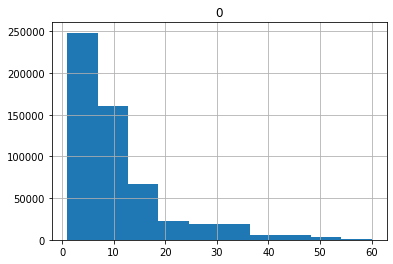

In [69]:
pd.DataFrame(model.predict(test_data)).hist()

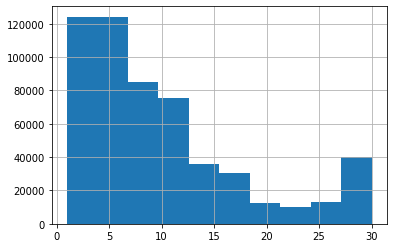

In [70]:
pd.DataFrame(model.predict(test_data)).apply(lambda x : x[0] if x[0]<30 else 30,axis=1).hist()

In [71]:
result = pd.DataFrame(model.predict_proba(test_data)).round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [72]:
result.loc[:,29] = result.loc[:,29:].sum(axis=1)

In [73]:
result.loc[:,:29].to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)